# <center> **Brief Video**

**Détection de mouvements répétitifs dans une vidéo - Déterminer le nombre de pompes**

- OpenCV pour extraire chaque frame puis les soumettre à Mediapipe,<br>
- Récupérer les landmarks (ou bien créer de nouvelles features en calculant l'angle entre 3 points),
- Features engineering pour déceler les variables plsu les plus pertinentes,
- Détecter les segments de vidéo où il y a un mouvement répétitif (étude de la stationnarité via un fenêtrage)


**landmarks** : repères corporels -> points d'intérêts constituant le squelette.

## **Sources**


**Remarque** : Run this notebook with environnement "time_series_video", in this env mediapipe was installed on python=3.12.7

**OpenCV**<br>
<code>pip install opencv-python</code><br>
<code>import cv2</code><br>
https://www.geeksforgeeks.org/opencv-python-tutorial/<br>
https://www.tresfacile.net/la-bibliotheque-opencv-python/<br>
<br>

**mediapipe**<br>
https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker?hl=fr<br>
<br>
**Tests de racine unitaire**<br>
https://fastercapital.com/fr/contenu/Root-de-l-unite--Comprendre-l-autocorrelation-en-series-chronologiques-stationnaires.html<br>
<br>




## **Imports**

In [ ]:
%reset

In [1]:
import os
import cv2
import PIL
import script # my tools
import itertools
import numpy as np
from scipy import stats
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt

# Scikit-Learn
# from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import root_mean_squared_error

# statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Path of the video
video_path = "videos/seq_a.mov"

#### **Code Bertrand**

In [2]:
script.code_Bertrand(video_path)

## **Counting number of frames**

In [3]:
cap = cv2.VideoCapture(video_path)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Nb frames:", length)

Nb frames: 512


## **Drawing landmarks**

Src: https://medium.com/@riddhisi238/real-time-pose-estimation-from-video-using-mediapipe-and-opencv-in-python-20f9f19c77a6<br>



In [4]:
df_landmarks = script.get_landmarks(video_path, "landmarks.csv")

In [4]:
df_landmarks = pd.read_csv('landmarks.csv')

In [60]:
df_landmarks

,Unnamed: 0,frame_number,landmark_id,x,y,z
0,0,0,NOSE,0.519619,0.032260,-0.172850
1,1,0,LEFT_EYE_INNER,0.525197,0.007496,-0.183628
2,2,0,LEFT_EYE,0.528531,0.006231,-0.183666
3,3,0,LEFT_EYE_OUTER,0.532272,0.005152,-0.183808
4,4,0,RIGHT_EYE_INNER,0.519305,0.010953,-0.150526
...,...,...,...,...,...,...
16528,16528,500,RIGHT_ANKLE,0.605784,0.667879,0.101312
16529,16529,500,LEFT_HEEL,0.664759,0.650310,0.056520
16530,16530,500,RIGHT_HEEL,0.613145,0.627570,0.143628
16531,16531,500,LEFT_FOOT_INDEX,0.686183,0.694064,0.125856


In [ ]:
x_min, x_max = df_landmarks.x.min(), df_landmarks.x.max()
y_min, y_max = df_landmarks.y.min(), df_landmarks.y.max()
z_min, z_max = df_landmarks.z.min(), df_landmarks.z.max()
(x_min, x_max, y_min, y_max, z_min, z_max)

### **Keep only a few landmarks**

In [18]:
df_landmarks['landmark_id'].unique().tolist()

['NOSE',
 'LEFT_EYE_INNER',
 'LEFT_EYE',
 'LEFT_EYE_OUTER',
 'RIGHT_EYE_INNER',
 'RIGHT_EYE',
 'RIGHT_EYE_OUTER',
 'LEFT_EAR',
 'RIGHT_EAR',
 'MOUTH_LEFT',
 'MOUTH_RIGHT',
 'LEFT_SHOULDER',
 'RIGHT_SHOULDER',
 'LEFT_ELBOW',
 'RIGHT_ELBOW',
 'LEFT_WRIST',
 'RIGHT_WRIST',
 'LEFT_PINKY',
 'RIGHT_PINKY',
 'LEFT_INDEX',
 'RIGHT_INDEX',
 'LEFT_THUMB',
 'RIGHT_THUMB',
 'LEFT_HIP',
 'RIGHT_HIP',
 'LEFT_KNEE',
 'RIGHT_KNEE',
 'LEFT_ANKLE',
 'RIGHT_ANKLE',
 'LEFT_HEEL',
 'RIGHT_HEEL',
 'LEFT_FOOT_INDEX',
 'RIGHT_FOOT_INDEX']

**Nous conservons 20 landmarks**

In [74]:
landmarks_to_keep = ['NOSE', 'MOUTH_LEFT', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW',
                     'LEFT_WRIST','RIGHT_WRIST', 'LEFT_INDEX', 'RIGHT_INDEX', 'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE',
                     'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL', 'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX']
landmarks_to_keep.sort()
landmarks_to_keep

['LEFT_ANKLE',
 'LEFT_ELBOW',
 'LEFT_FOOT_INDEX',
 'LEFT_HEEL',
 'LEFT_HIP',
 'LEFT_INDEX',
 'LEFT_KNEE',
 'LEFT_SHOULDER',
 'LEFT_WRIST',
 'MOUTH_LEFT',
 'NOSE',
 'RIGHT_ANKLE',
 'RIGHT_ELBOW',
 'RIGHT_FOOT_INDEX',
 'RIGHT_HEEL',
 'RIGHT_HIP',
 'RIGHT_INDEX',
 'RIGHT_KNEE',
 'RIGHT_SHOULDER',
 'RIGHT_WRIST']

In [62]:
df_20 = df_landmarks[df_landmarks['landmark_id'].isin(landmarks_to_keep)]
df_20

,Unnamed: 0,frame_number,landmark_id,x,y,z
0,0,0,NOSE,0.519619,0.032260,-0.172850
9,9,0,MOUTH_LEFT,0.531744,0.049320,-0.169289
11,11,0,LEFT_SHOULDER,0.632785,0.127311,-0.204843
12,12,0,RIGHT_SHOULDER,0.516047,0.151627,0.064681
13,13,0,LEFT_ELBOW,0.680340,0.315789,-0.211332
...,...,...,...,...,...,...
16528,16528,500,RIGHT_ANKLE,0.605784,0.667879,0.101312
16529,16529,500,LEFT_HEEL,0.664759,0.650310,0.056520
16530,16530,500,RIGHT_HEEL,0.613145,0.627570,0.143628
16531,16531,500,LEFT_FOOT_INDEX,0.686183,0.694064,0.125856


In [77]:
df_20_sorted = df_20.sort_values(by = ['landmark_id', 'frame_number'])
df_20_sorted.shape

(10020, 6)

In [ ]:
for i, row in df_20_sorted[:100].iterrows():
    print(row)

#### **Conversion vers un numpy array de dimension (501, 20, 3)**

In [78]:
arr_20 = df_20[['x', 'y', 'z']].values
print(arr_20.shape)
arr_20 = arr_20.reshape((501, 20, 3))
print(arr_20.shape)
arr_20

(10020, 3)
(501, 20, 3)


array([[[ 0.51961905,  0.03226039, -0.1728498 ],
        [ 0.53174365,  0.0493198 , -0.16928902],
        [ 0.63278455,  0.12731078, -0.20484325],
        ...,
        [ 0.61373925,  0.59935975,  0.53698301],
        [ 0.69017279,  0.69482452,  0.38801807],
        [ 0.62103295,  0.69393337,  0.6035558 ]],

       [[ 0.51957762,  0.03204063, -0.19798218],
        [ 0.53160447,  0.04916742, -0.19643487],
        [ 0.6312626 ,  0.12133236, -0.24748787],
        ...,
        [ 0.63533324,  0.60763907,  0.50136995],
        [ 0.6919179 ,  0.69924653,  0.33403856],
        [ 0.64740145,  0.6937933 ,  0.56688201]],

       [[ 0.51957756,  0.03325977, -0.23202161],
        [ 0.5316301 ,  0.04971821, -0.23044646],
        [ 0.62922269,  0.11782631, -0.28395128],
        ...,
        [ 0.63573241,  0.60710627,  0.48906827],
        [ 0.692002  ,  0.69910157,  0.32589474],
        [ 0.64874291,  0.6849457 ,  0.56511796]],

       ...,

       [[ 0.57958865,  0.11466185, -0.25266033],
        [ 0

In [70]:
arr_20_sorted = df_20_sorted[['x', 'y', 'z']].values
print(arr_20_sorted.shape)
arr_20_sorted = arr_20_sorted.reshape((501, 20, 3))
print(arr_20_sorted.shape)
arr_20_sorted

(10020, 3)
(501, 20, 3)


array([[[ 0.66855168,  0.64747256,  0.27516395],
        [ 0.67244291,  0.65197772,  0.21797259],
        [ 0.67418188,  0.65635705,  0.19467367],
        ...,
        [ 0.68066883,  0.65646529,  0.17679551],
        [ 0.68044424,  0.65641737,  0.17807558],
        [ 0.68047005,  0.65641999,  0.18653712]],

       [[ 0.68057561,  0.65645474,  0.1893197 ],
        [ 0.68058145,  0.65650088,  0.19043659],
        [ 0.68052572,  0.65652388,  0.19166131],
        ...,
        [ 0.68304998,  0.64199996,  0.14702807],
        [ 0.6806556 ,  0.64293605,  0.11186846],
        [ 0.6804921 ,  0.64382541,  0.13024789]],

       [[ 0.67762339,  0.64438254,  0.16041192],
        [ 0.67664683,  0.64470261,  0.18606395],
        [ 0.67682445,  0.65471709,  0.19581972],
        ...,
        [ 0.73886466,  0.57155752,  0.2247602 ],
        [ 0.73877347,  0.5687651 ,  0.23098369],
        [ 0.7399683 ,  0.56912434,  0.23400669]],

       ...,

       [[ 0.49836642,  0.53484458, -0.07954887],
        [ 0

## **Affichage des coordonnées par type de landmarks**

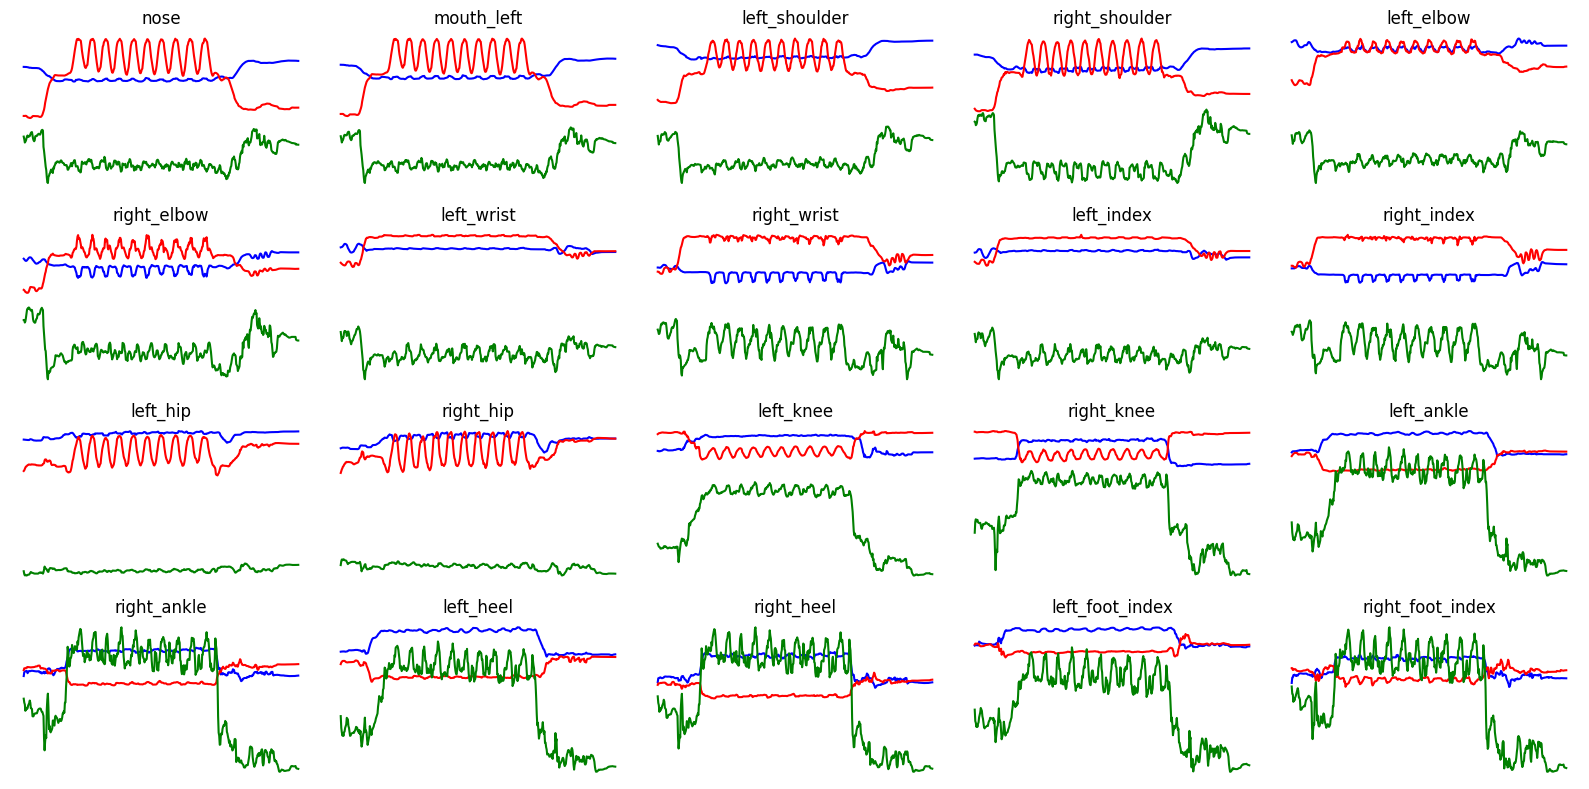

In [90]:
# Version with Pandas DataFrame
fig, ax = plt.subplots(4, 5, figsize=(16, 8))

for i in range(20):
    ax[i // 5, i % 5].plot(df_20[i::20]['x'], color = 'blue')
    ax[i // 5, i % 5].plot(df_20[i::20]['y'], color = 'red')
    ax[i // 5, i % 5].plot(df_20[i::20]['z'], color = 'green')
    ax[i // 5, i % 5].set_title(df_20.iloc[i]['landmark_id'].lower())
    ax[i // 5, i % 5].axis('off')

fig.tight_layout()

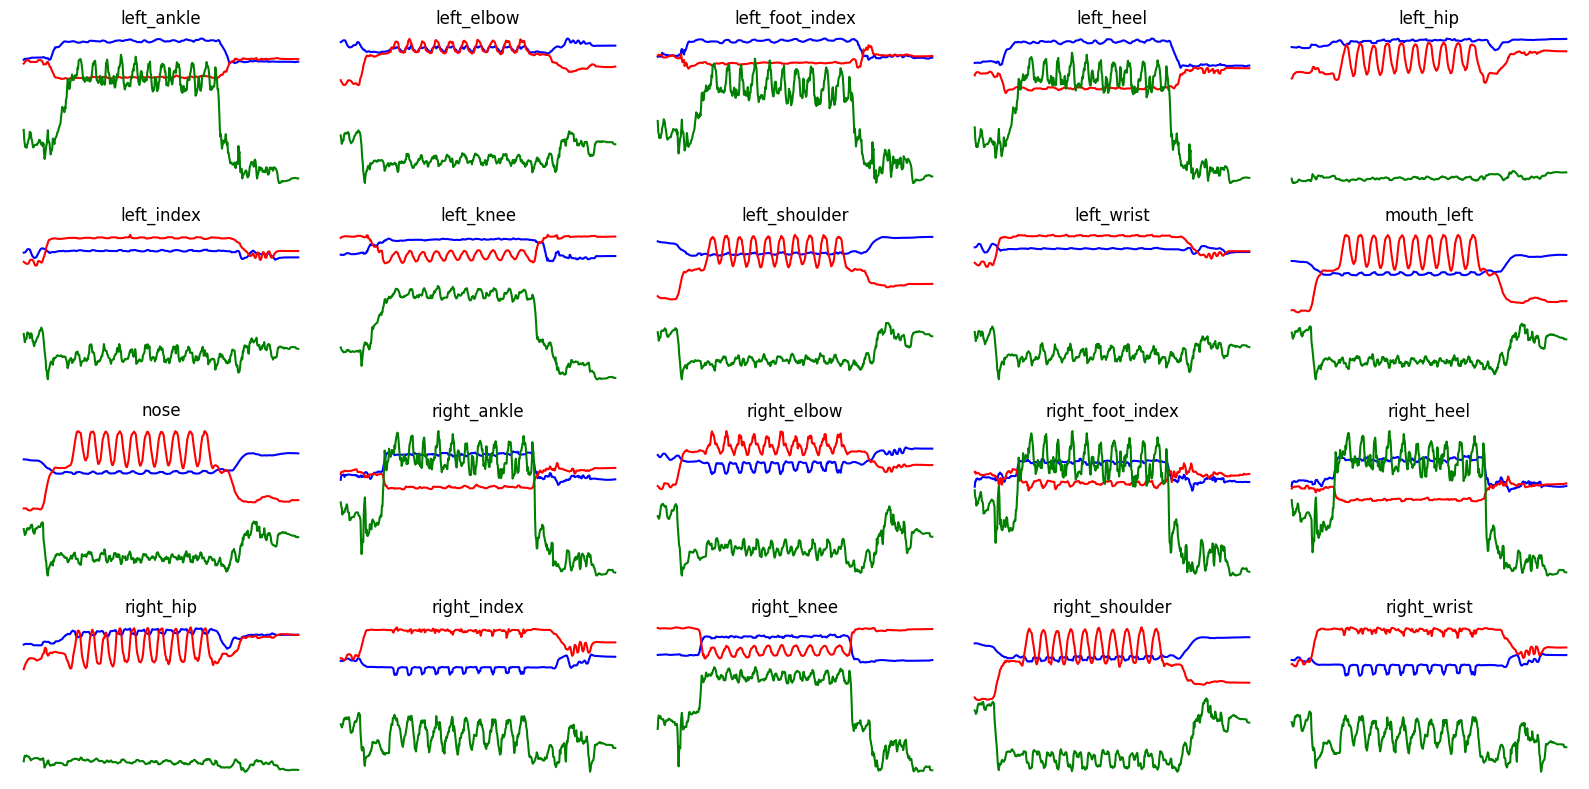

In [ ]:
# Version with SORTED Pandas DataFrame
fig, ax = plt.subplots(4, 5, figsize=(16, 8))

for i in range(20):
    ax[i // 5, i % 5].plot(df_20_sorted[501*i:501*(i+1):]['x'], color = 'blue')
    ax[i // 5, i % 5].plot(df_20_sorted[501*i:501*(i+1):]['y'], color = 'red')
    ax[i // 5, i % 5].plot(df_20_sorted[501*i:501*(i+1):]['z'], color = 'green')
    ax[i // 5, i % 5].set_title(landmarks_to_keep[i].lower())
    ax[i // 5, i % 5].axis('off')

fig.tight_layout()

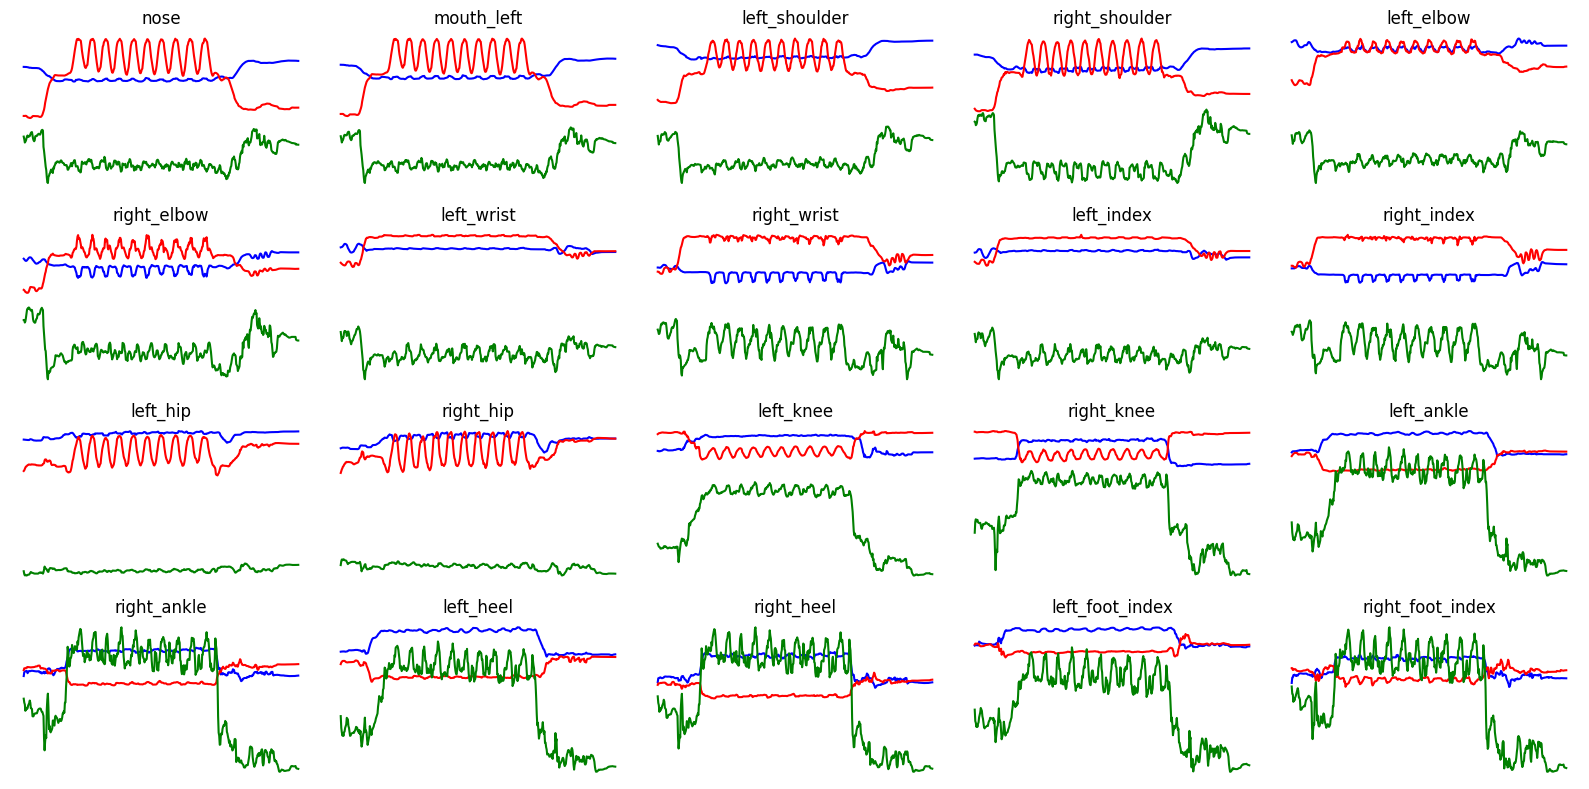

In [93]:
# Version with Numpy array
fig, ax = plt.subplots(4, 5, figsize=(16, 8))

for i in range(20):
    x = [arr_20[k][i][0] for k in range(501)]
    y = [arr_20[k][i][1] for k in range(501)]
    z = [arr_20[k][i][2] for k in range(501)]
    ax[i // 5, i % 5].plot(x, color = 'blue')
    ax[i // 5, i % 5].plot(y, color = 'red')
    ax[i // 5, i % 5].plot(z, color = 'green')
    ax[i // 5, i % 5].set_title(df_20.iloc[i]['landmark_id'].lower())
    ax[i // 5, i % 5].axis('off')

fig.tight_layout()

## **Recherche de stationnarité**

Nous utilisons le test de Dickey-Fuller de la librairie **Statsmodels**, ce test permet de déterminer si une série temporelle est stationnaire, c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varie dans le temps.

https://fr.wikipedia.org/wiki/Test_de_Dickey-Fuller<br>

In [96]:
def adfuller2(df, column):
    df_test = adfuller(df[column].values.tolist())
    # print("Coefficient ADF: ", adf)
    # print("La p-value du test de est de: ", pValue)
    dfoutput = pd.Series(
        df_test[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    return dfoutput

for i, landmark in enumerate(landmarks_to_keep):
    for column in ['x', 'y', 'z']:
        print(landmark, column)
        res = adfuller(df_20[i::20][column].values)
        print("Coefficient ADF: ", res[0])
        print("La p-value du test de est de: ", res[1])

LEFT_ANKLE x
Coefficient ADF:  -1.1194270189900106
La p-value du test de est de:  0.7072627862928065
LEFT_ANKLE y
Coefficient ADF:  -1.2122759405121126
La p-value du test de est de:  0.6682927444814621
LEFT_ANKLE z
Coefficient ADF:  -2.7686437344417287
La p-value du test de est de:  0.06289426002417675
LEFT_ELBOW x
Coefficient ADF:  -1.0226655536182285
La p-value du test de est de:  0.7449080649408908
LEFT_ELBOW y
Coefficient ADF:  -1.3054307148141477
La p-value du test de est de:  0.626684106974833
LEFT_ELBOW z
Coefficient ADF:  -2.5980479397488483
La p-value du test de est de:  0.09340139014800652
LEFT_FOOT_INDEX x
Coefficient ADF:  -0.9087477694933099
La p-value du test de est de:  0.7850780027744351
LEFT_FOOT_INDEX y
Coefficient ADF:  -1.7530419384174358
La p-value du test de est de:  0.404011439667703
LEFT_FOOT_INDEX z
Coefficient ADF:  -2.433973639568512
La p-value du test de est de:  0.13237624936411152
LEFT_HEEL x
Coefficient ADF:  -0.7489340894424543
La p-value du test de est 

**Conclusion** :<br> 
Stationnarité pour : "LEFT_KNEE z", "LEFT_WRIST z"

### **Test de Kruskal-Wallis-H**
Test d'indépendance pour 2 séries

In [ ]:
stats.kruskal(x, y)

## **Recherche de saisonnalité par landmark**

### **Feature NOSE**

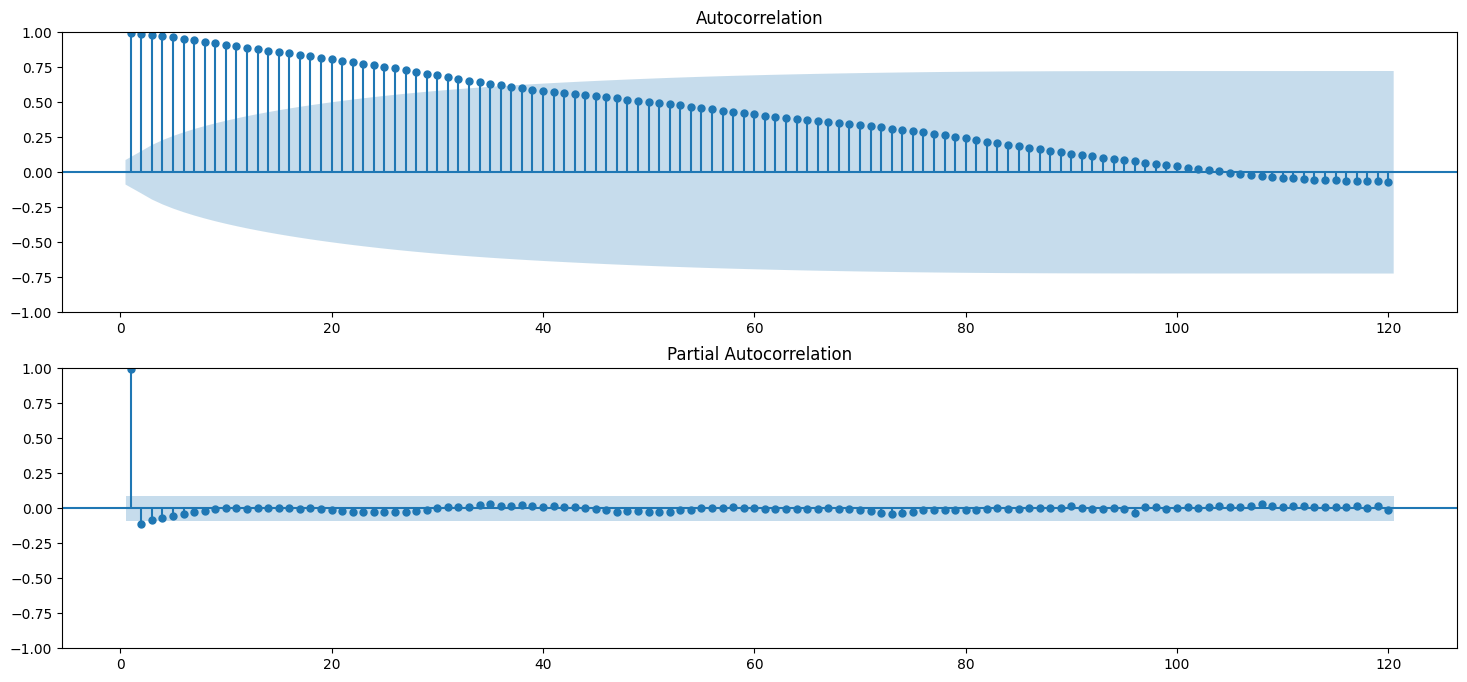

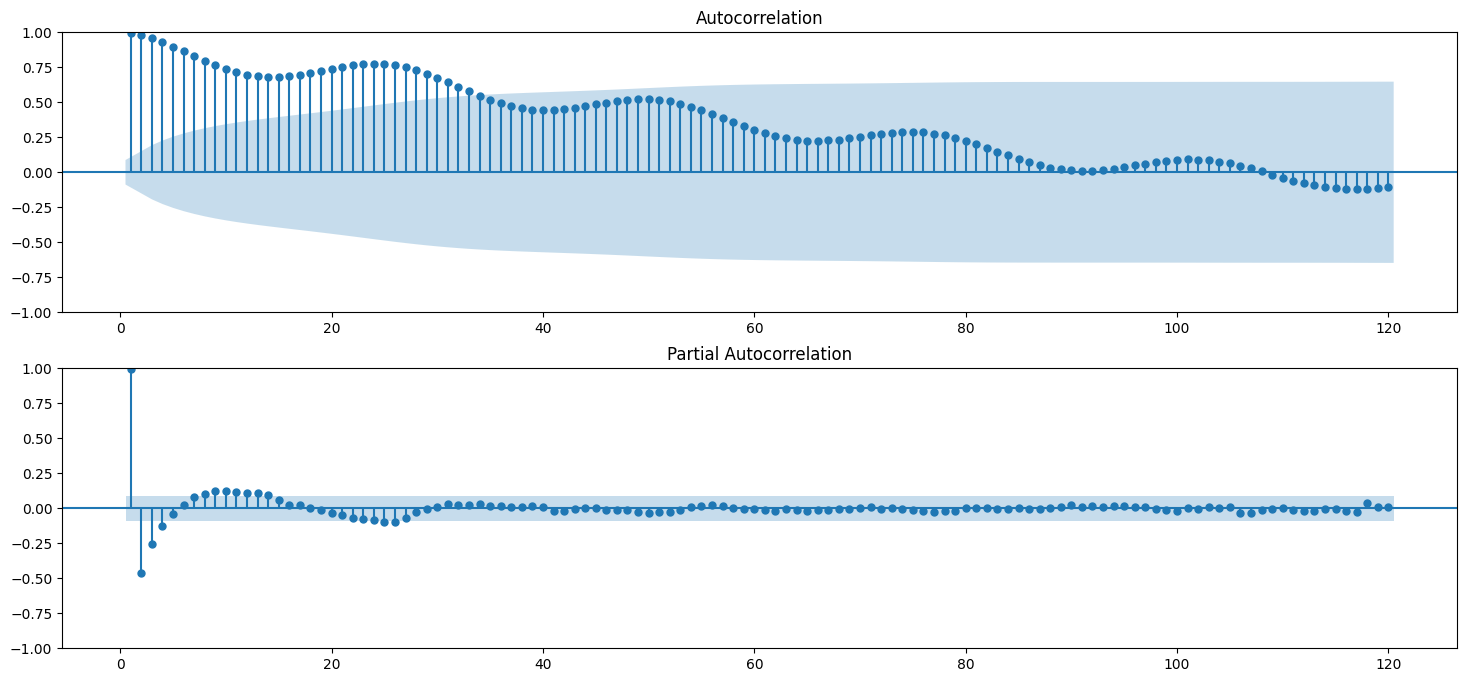

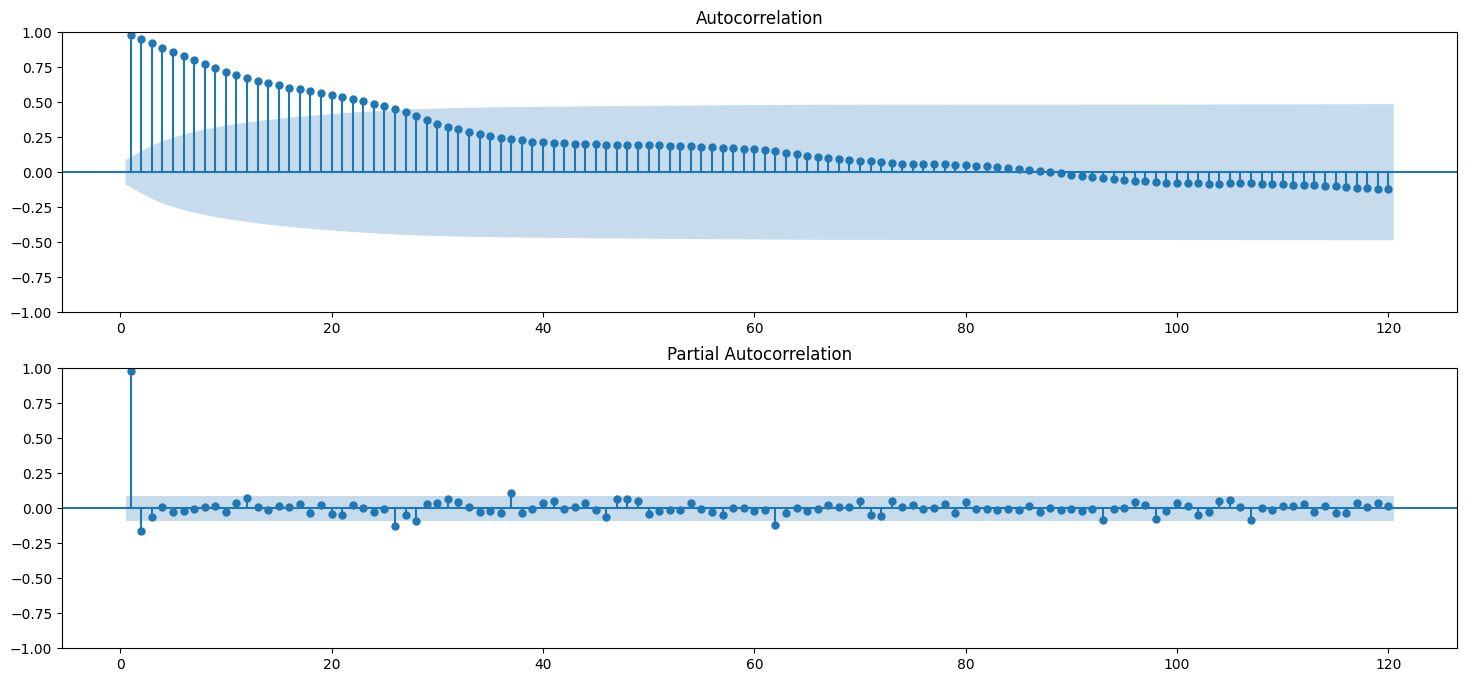

In [100]:
landmark = 0 # NOSE
for column in ['x', 'y', 'z']:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,8))
    plot_acf(df_20[landmark::20][column],  lags=120, zero=False, ax=ax1)
    plot_pacf(df_20[landmark::20][column], lags=120, zero=False, ax=ax2)

### **Recherche de saisonnalité par test de Dickey-Fuller avec fenêtre glissante**

On fait glisser une fenêtre (de taille 50 en général) sur l'ensemble des 501 frames et l'on calcule la pvalue du test de Dickey-Fuller, on cherche les zones contigües où la pvalue est inférieure à 5% pour délimiter une zone où il y a saisonnalité.

**NOSE**

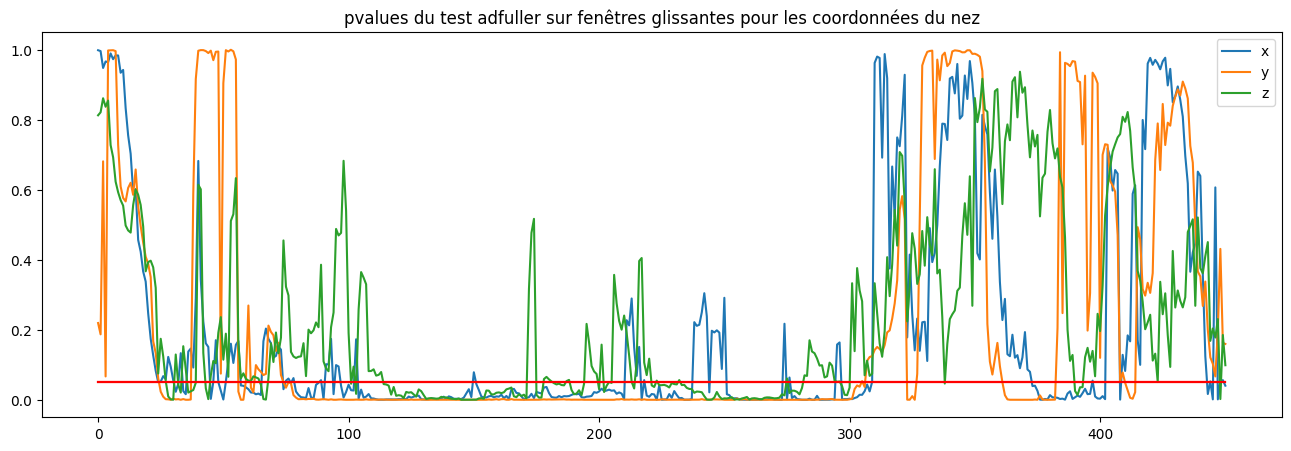

In [112]:
window   = 50
landmark = 0       # NOSE
column   = 'y'
df_temp = df_20[landmark::20]

fig = plt.figure(figsize=(16, 5))

for i, column in enumerate(['x', 'y', 'z']):
    pvalues = []

    for i in range(df_temp.shape[0] - window):
        res = adfuller(df_temp[i:i+window:][column].values)
        pvalues.append(res[1])

    # fig = plt.figure(figsize = (18, 6))
    plt.plot(pvalues, label = column)
    plt.plot([0.05] * len(pvalues), color='red')
    plt.legend()

plt.title('pvalues du test adfuller sur fenêtres glissantes pour les coordonnées du nez')
plt.show()

**Conclusion : Pour les valeurs y du landmark NOSE, la pvalue du test reste en dessous des 5%**<br>
On identifie toute une zone où il y a saisonnalité.
